# Satellite Image Segmentation — TensorFlow (Converted)

**Converted from**: `Notebook2_satellite_image_segmentation_pytorch_final.ipynb`

**What this notebook contains:**

- Dataset pipeline using `tf.data`
- Image / mask loading & preprocessing
- A U-Net implementation in `tf.keras`
- Training loop using `model.fit` with callbacks
- Visualization utilities

**Notes:** Adjust the `IMAGE_DIR`, `MASK_DIR`, and dataset splits to match your local paths.

In [1]:
# Basic imports and GPU setup
import os
import math
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print('TensorFlow version:', tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print('GPUs detected:', gpus)
    except Exception as e:
        print('GPU config error:', e)


2025-09-10 13:07:51.337970: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-10 13:07:51.411345: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-10 13:07:53.429239: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


TensorFlow version: 2.20.0
GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# === USER SETTINGS ===
IMAGE_DIR = 'Water Bodies Dataset/Images'   # Updated to local path
MASK_DIR  = 'Water Bodies Dataset/Masks'    # Updated to local path

IMAGE_GLOB = os.path.join("Water Bodies Dataset/Images", "*.jpg")
MASK_GLOB  = os.path.join("Water Bodies Dataset/Masks", "*.jpg")


BATCH_SIZE = 8
IMG_HEIGHT = 256
IMG_WIDTH  = 256
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42


In [3]:
# List image and mask files (matched by filename)
import os, glob

def pair_image_mask_paths(image_glob, mask_dir):
    image_paths = sorted(glob.glob(image_glob))
    pairs = []
    for img_path in image_paths:
        fname = os.path.basename(img_path)
        mask_path = os.path.join(mask_dir, fname)
        if os.path.exists(mask_path):
            pairs.append((img_path, mask_path))
    return pairs

pairs = pair_image_mask_paths(IMAGE_GLOB, MASK_DIR)
print('Found', len(pairs), 'image-mask pairs. Example:', pairs[:3])


Found 2841 image-mask pairs. Example: [('Water Bodies Dataset/Images/water_body_1.jpg', 'Water Bodies Dataset/Masks/water_body_1.jpg'), ('Water Bodies Dataset/Images/water_body_10.jpg', 'Water Bodies Dataset/Masks/water_body_10.jpg'), ('Water Bodies Dataset/Images/water_body_100.jpg', 'Water Bodies Dataset/Masks/water_body_100.jpg')]


In [4]:
# Image & mask loading + preprocessing functions
import tensorflow as tf

def read_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    return image

def read_mask(path):
    mask = tf.io.read_file(path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method='nearest')
    mask = tf.cast(mask > 127, tf.float32)
    return mask

def load_pair(image_path, mask_path):
    image = read_image(image_path)
    mask = read_mask(mask_path)
    return image, mask

# Simple augmentation example
def augment(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_brightness(image, 0.1)
    return image, mask


In [5]:
# Build tf.data pipeline
import random

def make_dataset(pairs, batch_size=8, augment_fn=None, shuffle=True):
    image_paths = [p for p,_ in pairs]
    mask_paths  = [m for _,m in pairs]
    ds = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(pairs), seed=SEED)
    ds = ds.map(lambda i,m: tf.py_function(func=lambda a,b: load_pair(a.numpy().decode('utf-8'), b.numpy().decode('utf-8')), inp=[i,m], Tout=[tf.float32, tf.float32]), num_parallel_calls=AUTOTUNE)
    def _set_shapes(img, msk):
        img.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
        msk.set_shape([IMG_HEIGHT, IMG_WIDTH, 1])
        return img, msk
    ds = ds.map(_set_shapes, num_parallel_calls=AUTOTUNE)
    if augment_fn is not None:
        ds = ds.map(lambda x,y: augment_fn(x,y), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

random.Random(SEED).shuffle(pairs)
n = len(pairs)
n_train = int(0.7 * n)
n_val   = int(0.2 * n)
train_pairs = pairs[:n_train]
val_pairs   = pairs[n_train:n_train+n_val]
test_pairs  = pairs[n_train+n_val:]

train_ds = make_dataset(train_pairs, augment_fn=augment, shuffle=True)
val_ds   = make_dataset(val_pairs, augment_fn=None, shuffle=False)
test_ds  = make_dataset(test_pairs, augment_fn=None, shuffle=False)

print('Train pairs:', len(train_pairs), 'Val pairs:', len(val_pairs), 'Test pairs:', len(test_pairs))


I0000 00:00:1757509674.632063   36065 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19539 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:00:05.0, compute capability: 8.0


Train pairs: 1988 Val pairs: 568 Test pairs: 285


In [6]:
# U-Net model (Keras)
from tensorflow.keras import layers

def conv_block(x, filters, kernel_size=3, padding='same', activation='relu'):
    x = layers.Conv2D(filters, kernel_size, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(filters, kernel_size, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    return x

def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D((2,2))(c)
    return c, p

def decoder_block(x, skip, filters):
    us = layers.UpSampling2D((2,2))(x)
    concat = layers.Concatenate()([us, skip])
    c = conv_block(concat, filters)
    return c

def build_unet(input_shape=(256,256,3), num_classes=1):
    inputs = layers.Input(shape=input_shape)
    c1, p1 = encoder_block(inputs, 64)
    c2, p2 = encoder_block(p1, 128)
    c3, p3 = encoder_block(p2, 256)
    c4, p4 = encoder_block(p3, 512)
    b = conv_block(p4, 1024)
    d1 = decoder_block(b, c4, 512)
    d2 = decoder_block(d1, c3, 256)
    d3 = decoder_block(d2, c2, 128)
    d4 = decoder_block(d3, c1, 64)
    outputs = layers.Conv2D(num_classes, (1,1), activation='sigmoid')(d4)
    model = keras.Model(inputs, outputs, name='UNet')
    return model

model = build_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
model.summary()


Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,402,497 (119.79 MB)

 Trainable params: 31,390,721 (119.75 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [7]:
# Losses & metrics
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = 1 - dice_coef(y_true, y_pred)
    return bce + dice

model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=bce_dice_loss,
              metrics=[dice_coef, 'accuracy'])


In [8]:
# Callbacks and training
checkpoint_path = 'unet_checkpoint.h5'
callbacks = [
    keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss'),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

EPOCHS = 20
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks
)


Epoch 1/20


2025-09-10 13:08:07.581489: I external/local_xla/xla/service/service.cc:163] XLA service 0x7544ec013730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-10 13:08:07.581516: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2025-09-10 13:08:07.996191: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-10 13:08:09.880701: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90701
2025-09-10 13:08:12.025093: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 25.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-09-10 13:08:12.079419: W externa

  2/249 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.5004 - dice_coef: 0.3456 - loss: 1.4187   

I0000 00:00:1757509710.983064   36286 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7781 - dice_coef: 0.5912 - loss: 0.9152

2025-09-10 13:08:53.061183: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 13:08:53.235055: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 13:08:53.529121: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 13:08:53.724939: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 13:08:54.286308: W external/local_xla/xla/tsl/fra

249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7783 - dice_coef: 0.5914 - loss: 0.9148

249/249 ━━━━━━━━━━━━━━━━━━━━ 78s 179ms/step - accuracy: 0.8118 - dice_coef: 0.6353 - loss: 0.8210 - val_accuracy: 0.3496 - val_dice_coef: 0.5027 - val_loss: 3.3882
Epoch 2/20
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8368 - dice_coef: 0.6764 - loss: 0.7419

249/249 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - accuracy: 0.8446 - dice_coef: 0.6856 - loss: 0.7073 - val_accuracy: 0.7622 - val_dice_coef: 0.6601 - val_loss: 1.0226
Epoch 3/20
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8566 - dice_coef: 0.7022 - loss: 0.6680

249/249 ━━━━━━━━━━━━━━━━━━━━ 24s 95ms/step - accuracy: 0.8548 - dice_coef: 0.7054 - loss: 0.6660 - val_accuracy: 0.8477 - val_dice_coef: 0.7230 - val_loss: 0.6997
Epoch 4/20
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8618 - dice_coef: 0.7154 - loss: 0.6393

249/249 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - accuracy: 0.8613 - dice_coef: 0.7167 - loss: 0.6408 - val_accuracy: 0.8497 - val_dice_coef: 0.7291 - val_loss: 0.6548
Epoch 5/20
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8720 - dice_coef: 0.7304 - loss: 0.6048

249/249 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - accuracy: 0.8726 - dice_coef: 0.7375 - loss: 0.5976 - val_accuracy: 0.8729 - val_dice_coef: 0.7687 - val_loss: 0.5725
Epoch 6/20
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8808 - dice_coef: 0.7541 - loss: 0.5613

249/249 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.8775 - dice_coef: 0.7458 - loss: 0.5784 - val_accuracy: 0.8721 - val_dice_coef: 0.7643 - val_loss: 0.5696
Epoch 7/20
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8773 - dice_coef: 0.7431 - loss: 0.5753

249/249 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - accuracy: 0.8790 - dice_coef: 0.7493 - loss: 0.5677 - val_accuracy: 0.8887 - val_dice_coef: 0.7830 - val_loss: 0.5219
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.8856 - dice_coef: 0.7639 - loss: 0.5420 - val_accuracy: 0.8500 - val_dice_coef: 0.7457 - val_loss: 0.6213
Epoch 9/20
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8886 - dice_coef: 0.7682 - loss: 0.5341

249/249 ━━━━━━━━━━━━━━━━━━━━ 24s 95ms/step - accuracy: 0.8906 - dice_coef: 0.7705 - loss: 0.5279 - val_accuracy: 0.8920 - val_dice_coef: 0.7802 - val_loss: 0.5061
Epoch 10/20
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8946 - dice_coef: 0.7817 - loss: 0.5033

249/249 ━━━━━━━━━━━━━━━━━━━━ 24s 95ms/step - accuracy: 0.8929 - dice_coef: 0.7776 - loss: 0.5115 - val_accuracy: 0.8933 - val_dice_coef: 0.7935 - val_loss: 0.4936
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.8953 - dice_coef: 0.7818 - loss: 0.5054 - val_accuracy: 0.8949 - val_dice_coef: 0.7946 - val_loss: 0.4985
Epoch 12/20
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8963 - dice_coef: 0.7803 - loss: 0.5032

249/249 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - accuracy: 0.8946 - dice_coef: 0.7805 - loss: 0.5057 - val_accuracy: 0.9037 - val_dice_coef: 0.8144 - val_loss: 0.4607
Epoch 13/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.9001 - dice_coef: 0.7909 - loss: 0.4805 - val_accuracy: 0.8791 - val_dice_coef: 0.7896 - val_loss: 0.5239
Epoch 14/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.8987 - dice_coef: 0.7866 - loss: 0.4918 - val_accuracy: 0.8979 - val_dice_coef: 0.7957 - val_loss: 0.4782
Epoch 15/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.9025 - dice_coef: 0.7951 - loss: 0.4727 - val_accuracy: 0.8905 - val_dice_coef: 0.7855 - val_loss: 0.4996
Epoch 16/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.9039 - dice_coef: 0.8005 - loss: 0.4647 - val_accuracy: 0.8973 - val_dice_coef: 0.7942 - val_loss: 0.4834
Epoch 17/20
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9036 - dice_coef: 0.8008 - loss: 0.4632

249/249 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - accuracy: 0.9041 - dice_coef: 0.7997 - loss: 0.4646 - val_accuracy: 0.9022 - val_dice_coef: 0.8085 - val_loss: 0.4541
Epoch 18/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.9084 - dice_coef: 0.8047 - loss: 0.4491 - val_accuracy: 0.8832 - val_dice_coef: 0.7871 - val_loss: 0.5192
Epoch 19/20
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9085 - dice_coef: 0.8036 - loss: 0.4529

249/249 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.9080 - dice_coef: 0.8066 - loss: 0.4494 - val_accuracy: 0.9076 - val_dice_coef: 0.8236 - val_loss: 0.4385
Epoch 20/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9109 - dice_coef: 0.8108 - loss: 0.4389 - val_accuracy: 0.9049 - val_dice_coef: 0.8141 - val_loss: 0.4522


34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8903 - dice_coef: 0.7898 - loss: 0.5065

2025-09-10 13:16:34.694469: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 13:16:34.868351: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 13:16:35.128556: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 13:16:35.324533: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.8880 - dice_coef: 0.7896 - loss: 0.5100
Test results (loss, dice, acc): [0.5100228190422058, 0.7895997166633606, 0.8880295157432556]


2025-09-10 13:16:39.164433: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 13:16:39.325192: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 13:16:39.590807: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 13:16:39.760969: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


2025-09-10 13:16:41.517176: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


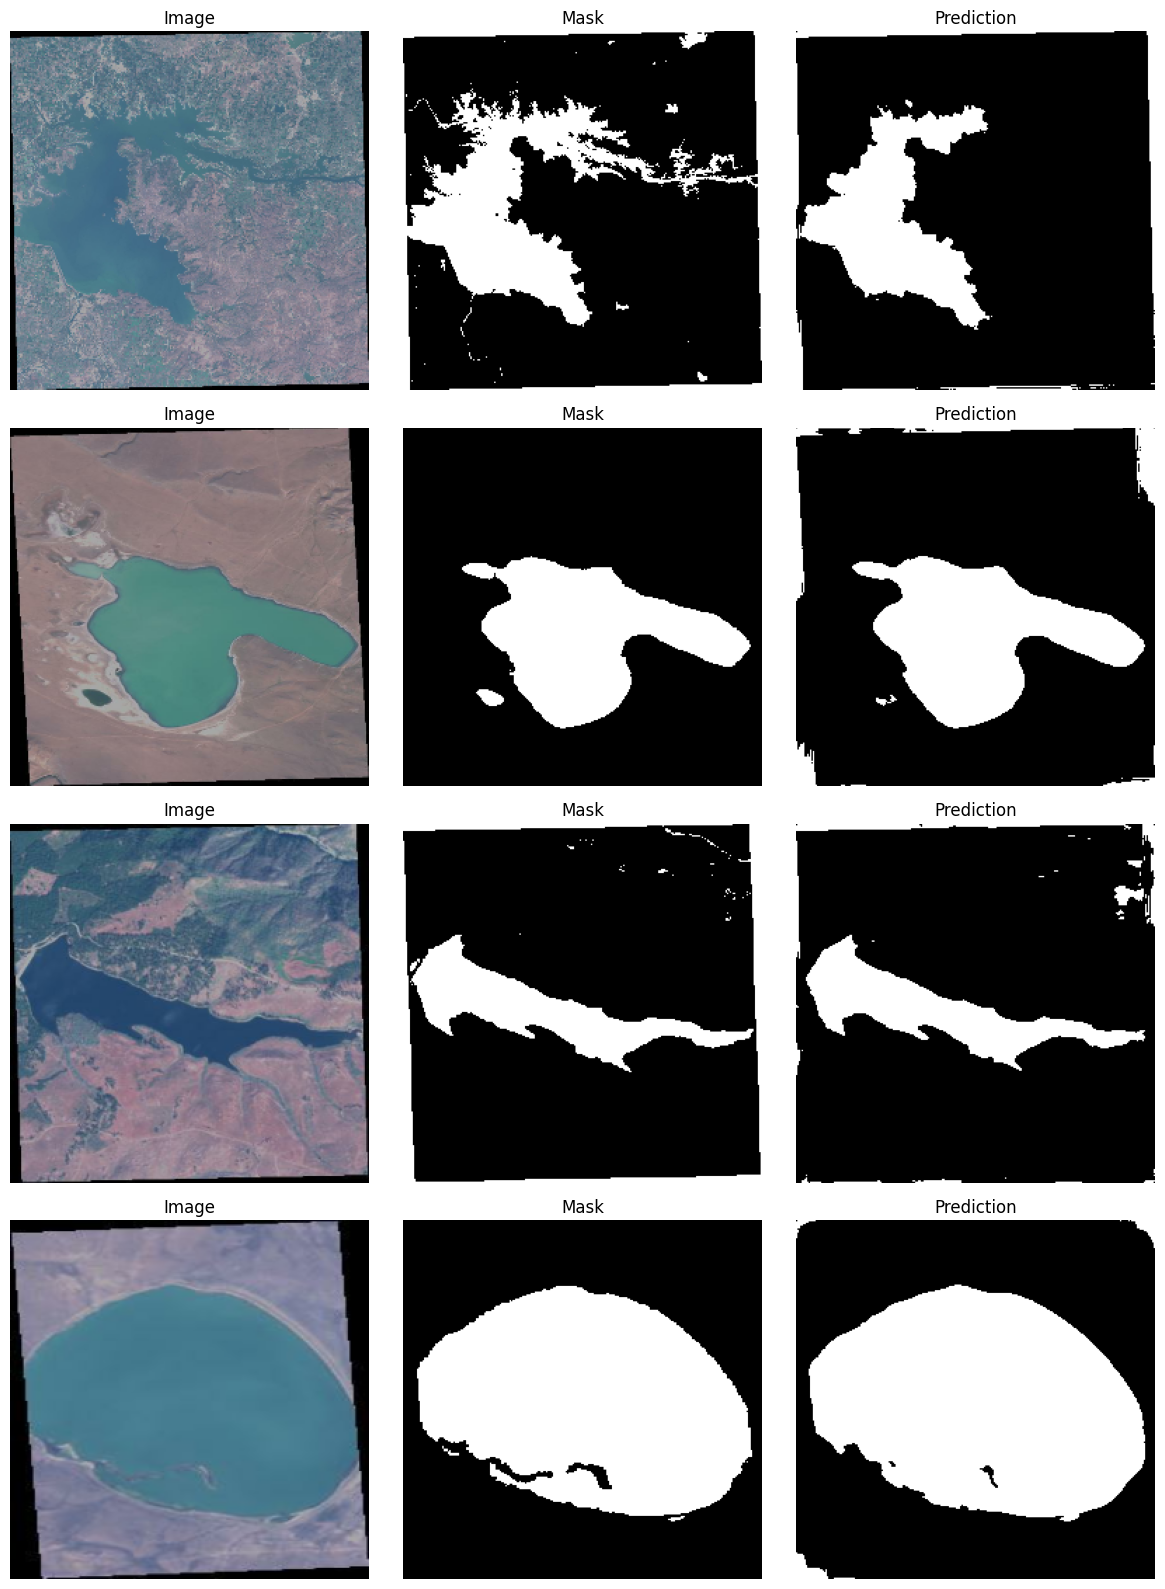

In [9]:
# Evaluate on test set
results = model.evaluate(test_ds)
print('Test results (loss, dice, acc):', results)

# Visualize predictions
import matplotlib.pyplot as plt

def visualize_samples(dataset, model, n=6):
    plt.figure(figsize=(12, 4*n))
    i = 0
    for imgs, masks in dataset.unbatch().take(n):
        pred = model.predict(tf.expand_dims(imgs, 0))[0]
        plt.subplot(n, 3, i*3 + 1)
        plt.imshow(imgs.numpy())
        plt.title('Image')
        plt.axis('off')
        plt.subplot(n, 3, i*3 + 2)
        plt.imshow(masks.numpy().squeeze(), cmap='gray')
        plt.title('Mask')
        plt.axis('off')
        plt.subplot(n, 3, i*3 + 3)
        plt.imshow((pred.squeeze() > 0.5).astype('float32'), cmap='gray')
        plt.title('Prediction')
        plt.axis('off')
        i += 1
    plt.tight_layout()

visualize_samples(val_ds, model, n=4)


## Saving the model

You can save the trained model for later inference:

```python
model.save('unet_saved_model')
```

Adjust any dataset paths or hyperparameters to match your original PyTorch notebook behaviour.

#Conclusion

Model used: U-Net (a convolutional encoder–decoder network for image segmentation).

Loss function used: A combination of Binary Cross-Entropy (BCE) and Dice Loss.